In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Flatten, GlobalMaxPooling2D
from tqdm import tqdm
import cv2


%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
input_img = Input(shape=(200, 200, 3))

In [6]:
# input_Inception = Input(shape=(200, 200, 3))
base_model_1 = Xception(include_top=False, input_tensor=input_img, weights="imagenet")
# base_model_1 = Xception(weights='imagenet', include_top=False)
model_1 = Model(inputs=base_model_1.input, outputs=base_model_1.get_layer('block14_sepconv1').output)
model_1_output = GlobalMaxPooling2D()(model_1.output)

# model_Xception = Xception(include_top=False, input_tensor=input_img, weights="imagenet")
# pooling_Xception = model_Xception.layers[-1].output
# flatten_Xception = GlobalAveragePooling2D()(pooling_Xception)

83683744/83683744 [==============================] - 3s 0us/step


In [7]:
# input_Xception = Input(shape=(200, 200, 3))
base_model_2 = InceptionV3(include_top=False, input_tensor=input_img, weights="imagenet")
# base_model_2 = InceptionV3(weights='imagenet', include_top=False)
output_layers = ['mixed7', 'mixed8', 'mixed9', 'mixed10']
model_2 = Model(inputs=base_model_2.input, outputs=[base_model_2.get_layer(layer_name).output for layer_name in output_layers])
model_2_outputs = [GlobalMaxPooling2D()(output) for output in model_2.outputs]

# model_Inception = InceptionV3(include_top=False, input_tensor=input_img, weights="imagenet")
# pooling_Inception = model_Inception.layers[-1].output
# flatten_Inception = GlobalAveragePooling2D()(pooling_Inception)

87910968/87910968 [==============================] - 3s 0us/step


In [8]:
concatenated = Concatenate(axis=-1)([model_1_output] + model_2_outputs)
# flatten_output = layers.Flatten(input_shape=(200, 200, 3))(concatenated)
# combined_model = Model([base_model_1.input, base_model_2.input], concatenated)

# concat = Concatenate()([flatten_Inception, flatten_Xception])

In [9]:
# Flatten the output layer to 1 dimension
# x1 = layers.GlobalMaxPooling2D()(last_output1)
# Add a fully connected layer with 512 hidden units and ReLU activation
output = layers.Dense(512, activation='relu')(concatenated)
# Add a dropout rate of 0.5
output = layers.Dropout(0.5)(output)
# Add a final sigmoid layer for classification
output = layers.Dense(4, activation='softmax')(output)

# Configure and compile the model
model = Model(inputs=input_img, outputs=output)
# model = Model(pre_trained_model1.input, x1)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200

In [10]:
for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.

print(x_train.shape)

100%|██████████| 1457/1457 [00:10<00:00, 145.27it/s]


(5712, 200, 200, 3)


In [11]:
for label in labels:
    testPath = os.path.join('/content/drive/MyDrive/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_test = np.array(x_test) / 255.0

print(x_test.shape)

100%|██████████| 300/300 [00:02<00:00, 148.67it/s]


(1311, 200, 200, 3)


In [12]:
x_train, y_train = shuffle(x_train,y_train,n_samples = 3000, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(600, 200, 200, 3)


In [13]:
y_test = tf.keras.utils.to_categorical(y_test)

In [14]:
x_train.shape, x_val.shape

((2400, 200, 200, 3), (600, 200, 200, 3))

In [15]:
y_train.shape, y_val.shape

((2400, 4), (600, 4))

In [17]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)

In [18]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 99, 99, 32)  96          ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [21]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_val, y_val),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

<ipython-input-21-ad5d8cf208b1>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/30
37/37 [==============================] - 89s 1s/step - loss: 1.1734 - acc: 0.6318 - val_loss: 0.7696 - val_acc: 0.7222 - lr: 1.0000e-04
Epoch 2/30
37/37 [==============================] - 54s 1s/step - loss: 0.3979 - acc: 0.8574 - val_loss: 0.5800 - val_acc: 0.7812 - lr: 1.0000e-04
Epoch 3/30
37/37 [==============================] - 47s 1s/step - loss: 0.2885 - acc: 0.8943 - val_loss: 0.4640 - val_acc: 0.8472 - lr: 1.0000e-04
Epoch 4/30
37/37 [==============================] - 47s 1s/step - loss: 0.2278 - acc: 0.9238 - val_loss: 0.2254 - val_acc: 0.9306 - lr: 1.0000e-04
Epoch 5/30
37/37 [==============================] - 48s 1s/step - loss: 0.1671 - acc: 0.9414 - val_loss: 0.4270 - val_acc: 0.8646 - lr: 1.0000e-04
Epoch 6/30
37/37 [==============================] - 48s 1s/step - loss: 0.1277 - acc: 0.9516 - val_loss: 0.2591 - val_acc: 0.9271 - lr: 1.0000e-04
Epoch 7/30
37/37 [==============================] - 49s 1s/step - loss: 0.1409 - acc: 0.9452 - val_loss: 0.1069 - val_

In [22]:
loss_val, acc_val = model.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

19/19 [==============================] - 5s 290ms/step - loss: 0.0589 - acc: 0.9850
Validation: accuracy = 0.985000  ;  loss_v = 0.058859


In [23]:
loss_test, acc_test = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

41/41 [==============================] - 10s 242ms/step - loss: 0.1333 - acc: 0.9710
Test: accuracy = 0.971014  ;  loss = 0.133297


In [29]:
model.save("/content/drive/My Drive/BTP/FINAL_B64_E30_L0001.h5")

In [7]:
model=tf.keras.models.load_model("/content/drive/My Drive/BTP/FINAL_B64_E30_L0001.h5")

In [16]:
y_pred = model.predict(x_test,verbose=1)


41/41 [==============================] - 22s 232ms/step


In [18]:
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'],loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'],loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.title('model_val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'])
plt.title('model_val_acc')
plt.ylabel(plt.xlabel('epoch')
'val_acc')
plt.legend(['train'],loc='upper left')
plt.show()

In [19]:
import matplotlib.pyplot as plt
# plt.figure(figsize=[8,6])
# plt.plot(history.history['loss'],'r',linewidth=3.0)
# plt.plot(history.history['val_loss'],'b',linewidth=3.0)
# plt.legend(['Training loss', 'Validation Loss'],fontsize=18
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.title('Loss Curves',fontsize=16)
# plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import learning_curve

In [21]:
y_predict=model.predict(x_test)
y_true=y_test
# res = tf.math.confusion_matrix(y_true,y_predict)

41/41 [==============================] - 7s 164ms/step


In [22]:
#cm = confusion_matrix(predict_class,y_test)
#y_pred = model.predict(x_test,verbose=1)
predict_class = np.argmax(y_pred, axis=1)
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

In [23]:
matrix

array([[282,  15,   0,   3],
       [  1, 292,   6,   7],
       [  1,   4, 400,   0],
       [  0,   1,   0, 299]])

In [24]:
from sklearn import metrics


In [26]:
import sklearn
!pip install -U scikit-learn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

y_predict=model.predict(x_test)
# predict_class= np.argmax(y_predict,axis=1)
y_true=y_test
# Compute fpr, tpr, thresholds and roc auc
roc_auc_score(y_true, y_predict,multi_class="ovr")
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate or (1 - Specifity)')
# plt.ylabel('True Positive Rate or (Sensitivity)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
41/41 [==============================] - 7s 166ms/step


0.9982351474197289

In [27]:

y_predict=model.predict(x_test)
y_true=y_test
# fpr, tpr = roc_curve(y_true,y_predict)

41/41 [==============================] - 7s 171ms/step


<Axes: >

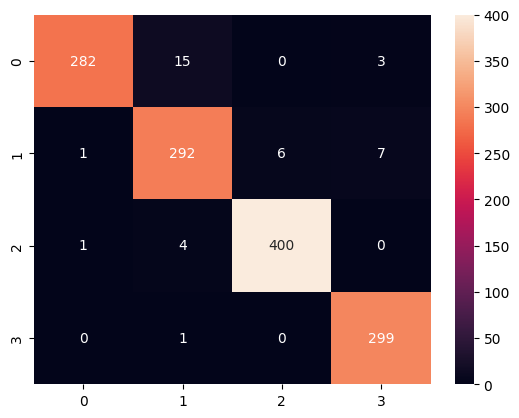

In [28]:
import seaborn as sns
sns.heatmap(matrix,annot = True,fmt='d')

In [29]:
from sklearn.metrics import f1_score
y_predict=model.predict(x_test)
y_true=y_test
f1_score(y_true.argmax(axis=1), y_predict.argmax(axis=1), average='weighted')

41/41 [==============================] - 7s 174ms/step


0.9709985800763171

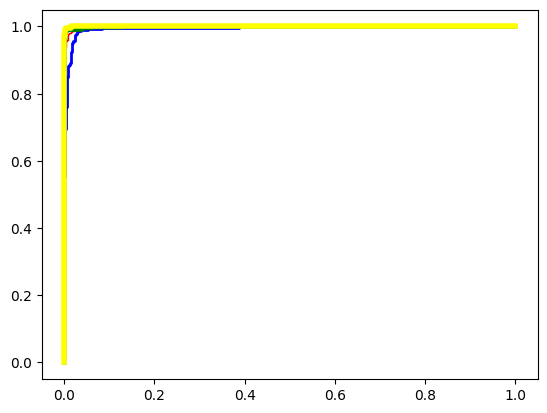

In [30]:
from sklearn.metrics import roc_curve,auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
lw = 2
color_arr=["red","blue","green","yellow"]
for i in range(4):
  plt.plot(
      fpr[i],
      tpr[i],
      color=color_arr[i],
      lw=i+1,
      label="ROC curve (area = %0.2f)" % roc_auc[i],
  )
plt.show()